# 粒子群优化算法 Particle Swarm Optimization

xyfJASON

## 1 概述

粒子群优化算法源自鸟群的不是行为，通过个体和群体的协作和信息共享寻找最优解。特点在于实现简单，没有过多需要调节的参数。粒子群优化算法善于解决连续函数的优化问题，对于诸如 TSP 等组合优化问题需要改动为广义粒子群优化，此处不做阐述。

粒子群优化算法步骤如下：

1. 初始化一群随机粒子，每个粒子具有速度和位置两个属性 $(v_i,x_i)$
2. 每个粒子按下述公式更新速度和位置：
   $$
   \begin{cases}
   v_i=\omega\cdot v_i+c_1\cdot \text{rand()}\cdot(\text{pbest}_i-x_i)+c_2\cdot\text{rand()}\cdot(\text{gbest}-x_i)\\
   x_i=x_i+v_i
   \end{cases}
   $$
   其中，$\text{rand()}$ 是 $[0,1]$ 之间的随机数，$c_1,c_2$ 是系数，$\text{pbest}_i$ 是该粒子自身到达的最佳点，$\text{gbest}$ 是群体到达过的最佳点。
   $\omega$ 是惯性因子，可线性递减动态调节：
   $$
   \omega^{(t)}=(\omega_\text{ini}-\omega_\text{end})(G-g)/G+\omega_\text{end}
   $$
   其中，$\omega_\text{ini},\omega_\text{end}$ 分别是初始、结束惯性因子，$G$ 是最大迭代次数，$g$ 是当前迭代次数
3. 重复步骤 2 直至到达最大迭代次数

## 2 代码模板

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm


class ParticleSwarmOptimization:
    """
    To run PSO, inherit this class, then
    override 'gen_init_particles` and `evaluate_particles`.
    """
    def __init__(self,
                 n_particle: int,
                 T: int,
                 c1: float = 2,
                 c2: float = 2,
                 omega_init: float = 0.9,
                 omega_end: float = 0.4,
                 lb: np.ndarray = None,
                 ub: np.ndarray = None) -> None:
        """
        :param n_particle: number of particles
        :param T: maximum iterations
        :param c1: factor
        :param c2: factor
        :param omega_init: factor
        :param omega_end: factor
        :param lb: lower bound of particles
        :param ub: upper bound of particles
        """
        self.n_particle = n_particle
        self.T = T
        self.c1 = c1
        self.c2 = c2
        self.omega_init = omega_init
        self.omega_end = omega_end
        self.lb, self.ub = lb, ub
        self.v, self.p = self.gen_init_particles()
        assert self.v.shape == self.p.shape and len(self.v.shape) == 2
        assert self.v.shape[0] == n_particle
        self.n_dim = self.v.shape[1]
        assert self.lb.shape == self.ub.shape == self.v.shape
        self.record_gbest = []
        self.record_scores = []

    def reset(self) -> None:
        self.v, self.p = self.gen_init_particles()
        self.n_dim = self.v.shape[1]
        self.record_gbest = []
        self.record_scores = []

    def gen_init_particles(self) -> tuple[np.ndarray, np.ndarray]:
        """
        Return two ndarray of the same size [n_particle, K]
        The first ndarray is the velocity of particles
        The second ndarray is the position of particles
        """
        raise NotImplementedError

    def evaluate_particles(self, p: np.ndarray) -> np.ndarray:
        """
        :param p: [N, k], position of particles
        :return: [N], scores of each particle, the higher the better
        """
        raise NotImplementedError

    def run(self) -> np.ndarray:
        pbest = self.p.copy()  # [N, K]
        pbest_scores = self.evaluate_particles(pbest)  # [N]
        gbest = pbest[np.argmax(pbest_scores)]  # [K]
        gbest_scores = np.max(pbest_scores)  # [1]
        for t in tqdm(range(self.T)):
            omega = (self.omega_init - self.omega_end) * (self.T - t) / self.T + self.omega_end
            self.v = (
                    omega * self.v +
                    self.c1 * np.random.rand(self.n_particle, 1) * (pbest - self.p) +
                    self.c2 * np.random.rand(self.n_particle, 1) * (gbest - self.p)
            )
            self.p += self.v
            self.p = np.clip(self.p, self.lb, self.ub)
            scores = self.evaluate_particles(self.p)  # [N]
            update_mask = (pbest_scores < scores)
            pbest[update_mask] = self.p[update_mask]
            pbest_scores[update_mask] = scores[update_mask]
            if gbest_scores < np.max(pbest_scores):
                gbest_scores = np.max(pbest_scores)
                gbest = pbest[np.argmax(pbest_scores)]
            self.record_gbest.append(gbest_scores)
            self.record_scores.append(scores)
        return gbest

    def plot(self, history: bool = True, best: bool = True) -> None:
        fig, ax = plt.subplots(1, 1)
        assert history or best
        ax.set_title('Score curve')
        ax.set_xlabel('Iters')
        ax.set_ylabel('Score')
        if history:
            record = np.vstack(self.record_scores)
            ax.errorbar(x=range(1, self.T+1),
                        y=record.mean(axis=1),
                        yerr=np.max(record, axis=1)-record.mean(axis=1),
                        fmt='.',
                        c='dodgerblue', label='history')
        if best:
            ax.plot(range(1, self.T+1), self.record_gbest, label='best', c='darkorange')
        plt.legend()
        plt.show()

## 3 例题

求下列函数在 $[-3,3]^2$ 上的最大值：
$$
F(x,y)=3(1-x)^2e^{-x^2-(y+1)^2}-10\left(\frac{x}{5}-x^3-y^5\right)e^{-x^2-y^2}-\frac{1}{3}^{\exp\left(-(x+1)^2-y^2\right)}
$$
代码如下：

100%|███████████████████████████████████████| 100/100 [00:00<00:00, 8206.91it/s]


[-0.01477502  1.57699404] 7.15019499494628


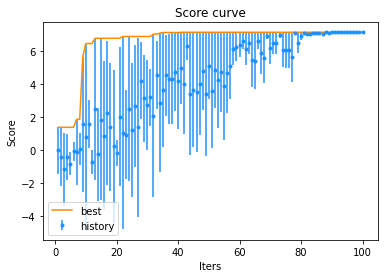

In [2]:
def F(x, y):
    return 3*(1-x)**2*np.exp(-(x**2)-(y+1)**2)-10*(x/5-x**3-y**5)*np.exp(-x**2-y**2)-1/3**np.exp(-(x+1)**2-y**2)

n = 5

class Solver(ParticleSwarmOptimization):
    def gen_init_particles(self) -> tuple[np.ndarray, np.ndarray]:
        v = np.random.rand(n, 2) * 2 - 1
        p = np.random.rand(n, 2) * 6 - 3
        return v, p

    def evaluate_particles(self, p: np.ndarray) -> np.ndarray:
        return F(p[:, 0], p[:, 1])

solver = Solver(n_particle=n,
                T=100,
                lb=np.ones((n, 2))*-3,
                ub=np.ones((n, 2))*3)
res = solver.run()
print(res, F(res[0], res[1]))
solver.plot()